# Phân tích Dữ liệu MovieLens 1M: Độ Phân Hóa Ý Kiến Người Xem

## Lời mở đầu
Dự án này phân tích dữ liệu MovieLens 1M để hiểu rõ hơn về **độ phân hóa ý kiến người xem** (opinion polarization) đối với các bộ phim. Chúng ta sẽ khám phá các yếu tố ảnh hưởng đến mức độ đồng thuận hoặc bất đồng ý kiến thông qua độ lệch chuẩn của điểm đánh giá.

### Các nhóm câu hỏi nghiên cứu:
1. **Thống kê mô tả**: Đặc điểm và khuynh hướng chung
2. **Phân tích khám phá**: Nguyên nhân và yếu tố ảnh hưởng
3. **Phân tích dự đoán**: Mô hình dự báo độ phân hóa
4. **Phân tích so sánh**: So sánh giữa các nhóm
5. **Phân tích mở rộng**: Liên hệ đến ứng dụng thực tế

MovieLens 1M là bộ dữ liệu chứa khoảng một triệu đánh giá phim, do ~6.000 người dùng đánh giá ~4.000 phim. Dữ liệu được chia thành 3 bảng nhỏ:

ratings: các đánh giá của người dùng  
users: thông tin người dùng (tuổi, giới tính, nghề nghiệp, mã bưu điện)  
movies: thông tin phim (thể loại, năm)  
Bộ dữ liệu hữu ích cho việc phát triển hệ gợi ý. Để dùng trong Python/Jupyter, ta thường tải mỗi bảng vào pandas DataFrame bằng pandas.read_table — chạy đoạn code tương ứng trong một ô Jupyter.


In [1]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Bước 1: Tải và Chuẩn Bị Dữ Liệu

In [3]:
# Đọc dữ liệu từ file users.dat
unames = ["user_id", "gender", "age", "occupation", "zip"]
users = pd.read_table("datasets/movielens/users.dat", sep="::",
                      header=None, names=unames, engine="python")

In [4]:
# Đọc dữ liệu từ file ratings.dat
rnames = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_table("datasets/movielens/ratings.dat", sep="::",
                        header=None, names=rnames, engine="python")

In [6]:
# Đọc dữ liệu từ file movies.dat
mnames = ["movie_id", "title", "genres"]
movies = pd.read_table("datasets/movielens/movies.dat", sep="::",
                       header=None, names=mnames, engine="python")

In [7]:
# In ra kích thước của các tập dữ liệu
print(f"Số người dùng: {len(users)}")
print(f"Số lượt đánh giá: {len(ratings)}")
print(f"Số phim: {len(movies)}")

Số người dùng: 6040
Số lượt đánh giá: 1000209
Số phim: 3883


In [8]:
# Kết hợp ba DataFrame thành một
data = pd.merge(pd.merge(ratings, users), movies)
print(f"Dữ liệu kết hợp có hình dạng: {data.shape}")
print("\nXem 5 dòng đầu tiên:")
data.head()

Dữ liệu kết hợp có hình dạng: (1000209, 10)

Xem 5 dòng đầu tiên:


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [9]:
# Tách năm phát hành từ tiêu đề phim (ở cuối tiêu đề, trong ngoặc)
data['release_year'] = data['title'].str.extract(r'\((\d{4})\)$').astype(int)

In [10]:
# Tách từng thể loại phim thành các hàng riêng (explode)
# Trước tiên, tách chuỗi thể loại
data['genres'] = data['genres'].str.split('|')

# Kiểm tra dữ liệu trước khi explode
print("Kiểm tra dữ liệu trước explode:")
print(data[['title', 'genres']].head())
print(f"\nKích thước trước explode: {data.shape}")

Kiểm tra dữ liệu trước explode:
                                    title                            genres
0  One Flew Over the Cuckoo's Nest (1975)                           [Drama]
1        James and the Giant Peach (1996)  [Animation, Children's, Musical]
2                     My Fair Lady (1964)                [Musical, Romance]
3                  Erin Brockovich (2000)                           [Drama]
4                    Bug's Life, A (1998)   [Animation, Children's, Comedy]

Kích thước trước explode: (1000209, 11)


In [11]:
# Explode genres để có một dòng cho mỗi thể loại
data_exploded = data.explode('genres')
data_exploded = data_exploded.reset_index(drop=True)

print(f"Kích thước sau explode: {data_exploded.shape}")
print(f"\nSố thể loại duy nhất: {data_exploded['genres'].nunique()}")
print(f"Các thể loại: {sorted(data_exploded['genres'].unique())}")

Kích thước sau explode: (2101815, 11)

Số thể loại duy nhất: 18
Các thể loại: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [12]:
# Tạo phân loại nhóm tuổi
def categorize_age(age):
    if age < 18:
        return 'Under 18'
    elif age < 25:
        return '18-24'
    elif age < 35:
        return '25-34'
    elif age < 45:
        return '35-44'
    elif age < 50:
        return '45-49'
    else:
        return '50+'

data['age_group'] = data['age'].apply(categorize_age)
data_exploded['age_group'] = data_exploded['age'].apply(categorize_age)

print("Phân bố người dùng theo nhóm tuổi:")
print(data['age_group'].value_counts().sort_index())

Phân bố người dùng theo nhóm tuổi:
age_group
18-24       183536
25-34       395556
35-44       199003
45-49        83633
50+         111270
Under 18     27211
Name: count, dtype: int64


---

# Phần 1: Thống Kê Mô Tả - Khám Phá Sự Phân Hóa Ý Kiến

## 1.1 - Các phim có độ lệch chuẩn rating cao nhất

### Câu hỏi:
"Những bộ phim nào trong tập dữ liệu MovieLens 1M thể hiện sự phân hóa ý kiến người xem mạnh nhất, thể hiện qua độ lệch chuẩn của điểm đánh giá cao nhất?"

In [13]:
# Tính độ lệch chuẩn, trung bình, và số lượng đánh giá cho mỗi phim
movie_stats = data.groupby('title')['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).reset_index()

In [14]:
# Lọc các phim có ít nhất 100 lượt đánh giá
movie_stats_filtered = movie_stats[movie_stats['count'] >= 100].copy()

In [15]:
# Sắp xếp theo độ lệch chuẩn giảm dần
movie_stats_filtered = movie_stats_filtered.sort_values('std', ascending=False)

In [16]:
# In ra kết quả
print(f"Tổng số phim được phân tích: {len(movie_stats_filtered)}")
print("\n10 phim có độ lệch chuẩn rating cao nhất (gây tranh cãi nhất):")
print(movie_stats_filtered[['title', 'count', 'mean', 'std']].head(10).to_string())

Tổng số phim được phân tích: 2019

10 phim có độ lệch chuẩn rating cao nhất (gây tranh cãi nhất):
                                               title  count      mean       std
2587                  Plan 9 from Outer Space (1958)    249  2.634538  1.455998
344                                   Beloved (1998)    104  3.134615  1.372813
1363  Godzilla 2000 (Gojira ni-sen mireniamu) (1999)    143  2.692308  1.364700
3301             Texas Chainsaw Massacre, The (1974)    247  3.222672  1.332448
1001                            Dumb & Dumber (1994)    660  3.192424  1.321333
781                                     Crash (1996)    141  2.758865  1.319636
423                  Blair Witch Project, The (1999)   1237  3.031528  1.316368
2328                     Natural Born Killers (1994)    700  3.144286  1.307198
973                               Down to You (2000)    122  2.688525  1.305310
633       Cemetery Man (Dellamorte Dellamore) (1994)    101  3.356436  1.300647


In [17]:
# Thống kê tổng quan về độ lệch chuẩn
print("\nThống kê mô tả về độ lệch chuẩn rating:")
print(movie_stats_filtered['std'].describe())


Thống kê mô tả về độ lệch chuẩn rating:
count    2019.000000
mean        0.988677
std         0.113611
min         0.667143
25%         0.909700
50%         0.982879
75%         1.063244
max         1.455998
Name: std, dtype: float64


In [18]:
# Tính các phân vị
percentiles = [10, 25, 50, 75, 90, 95]
print(f"\nPhân vị độ lệch chuẩn:")
for p in percentiles:
    value = movie_stats_filtered['std'].quantile(p/100)
    print(f"  {p}th percentile: {value:.4f}")


Phân vị độ lệch chuẩn:
  10th percentile: 0.8446
  25th percentile: 0.9097
  50th percentile: 0.9829
  75th percentile: 1.0632
  90th percentile: 1.1376
  95th percentile: 1.1874


## 1.2 - Phân bố độ lệch chuẩn rating và nhóm phim "gây tranh cãi"

### Câu hỏi:
"Phân bố của độ lệch chuẩn rating giữa các phim như thế nào? Có tồn tại nhóm phim 'gây tranh cãi' vượt trội so với trung bình không?"

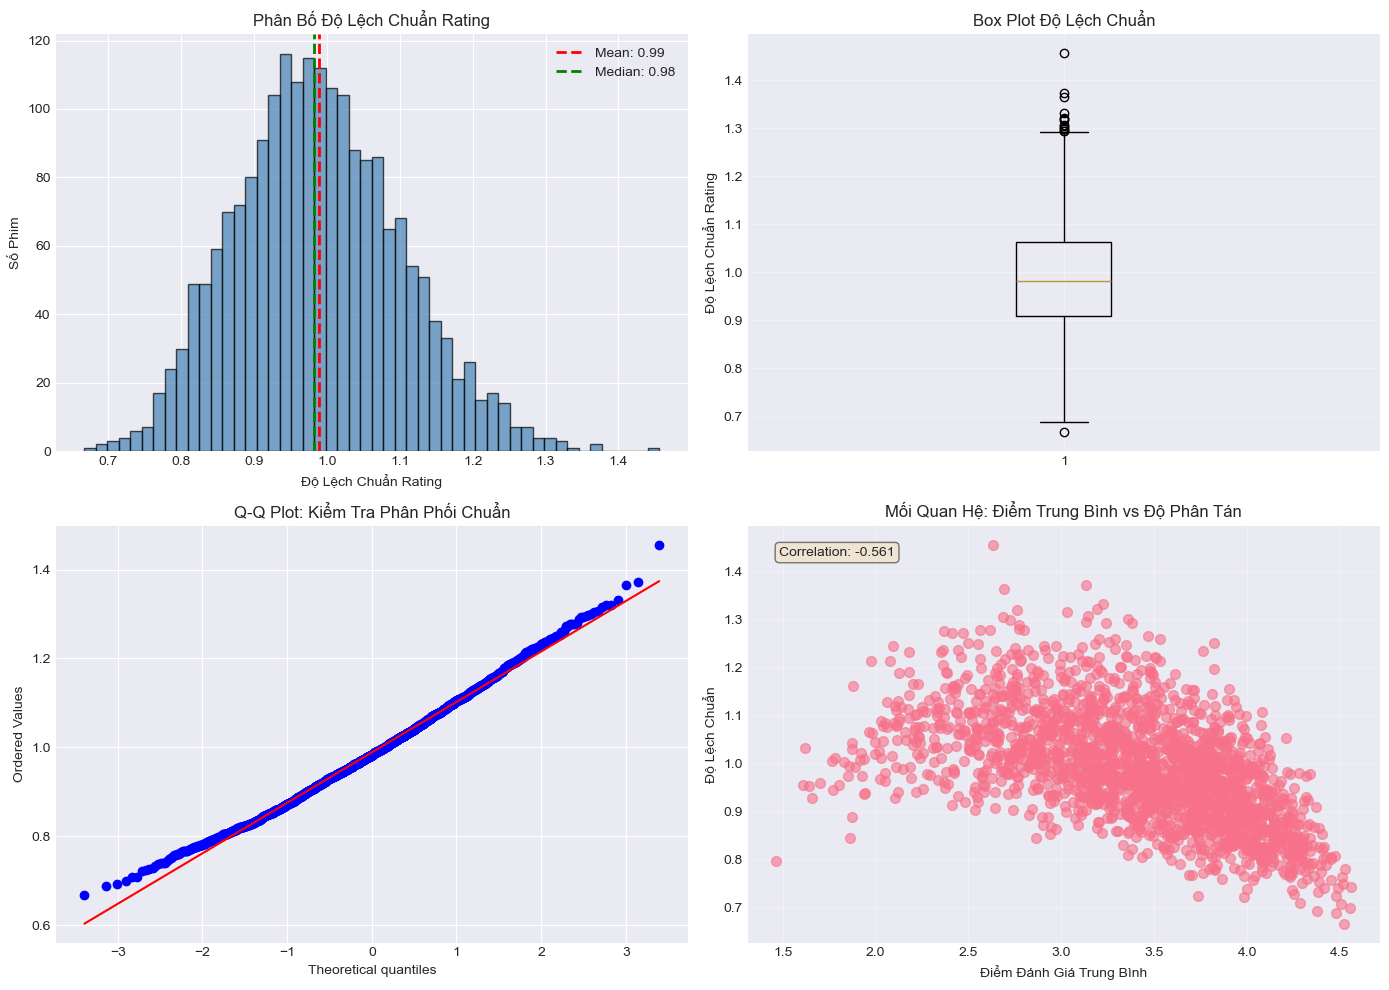

Tương quan giữa Mean rating và Std: -0.5605


In [19]:
# Tạo biểu đồ phân bố độ lệch chuẩn
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram độ lệch chuẩn
axes[0, 0].hist(movie_stats_filtered['std'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(movie_stats_filtered['std'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {movie_stats_filtered['std'].mean():.2f}")
axes[0, 0].axvline(movie_stats_filtered['std'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {movie_stats_filtered['std'].median():.2f}")
axes[0, 0].set_xlabel('Độ Lệch Chuẩn Rating')
axes[0, 0].set_ylabel('Số Phim')
axes[0, 0].set_title('Phân Bố Độ Lệch Chuẩn Rating')
axes[0, 0].legend()

# 2. Box plot độ lệch chuẩn
axes[0, 1].boxplot(movie_stats_filtered['std'], vert=True)
axes[0, 1].set_ylabel('Độ Lệch Chuẩn Rating')
axes[0, 1].set_title('Box Plot Độ Lệch Chuẩn')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot để kiểm tra tính chuẩn tắc
stats.probplot(movie_stats_filtered['std'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Kiểm Tra Phân Phối Chuẩn')

# 4. Biểu đồ scatter: Mean vs Std
axes[1, 1].scatter(movie_stats_filtered['mean'], movie_stats_filtered['std'], alpha=0.6, s=50)
axes[1, 1].set_xlabel('Điểm Đánh Giá Trung Bình')
axes[1, 1].set_ylabel('Độ Lệch Chuẩn')
axes[1, 1].set_title('Mối Quan Hệ: Điểm Trung Bình vs Độ Phân Tán')
axes[1, 1].grid(True, alpha=0.3)

# Tính tương quan
corr = movie_stats_filtered['mean'].corr(movie_stats_filtered['std'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[1, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('movies_std_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"Tương quan giữa Mean rating và Std: {corr:.4f}")

In [20]:
# Xác định nhóm phim "gây tranh cãi"
# Phim gây tranh cãi: có độ lệch chuẩn >= percentile 90
q90 = movie_stats_filtered['std'].quantile(0.90)
controversial_movies = movie_stats_filtered[movie_stats_filtered['std'] >= q90]

print(f"Ngưỡng Std cho phim 'gây tranh cãi' (90th percentile): {q90:.4f}")
print(f"Số phim 'gây tranh cãi': {len(controversial_movies)}")
print(f"Phần trăm: {len(controversial_movies) / len(movie_stats_filtered) * 100:.2f}%")

print("\nTop 15 phim 'gây tranh cãi' nhất:")
controversial_display = controversial_movies[['title', 'count', 'mean', 'std']].head(15)
for idx, row in controversial_display.iterrows():
    print(f"  • {row['title'][:50]:<50} | Rating trung bình: {row['mean']:.2f} | Std: {row['std']:.4f}")

Ngưỡng Std cho phim 'gây tranh cãi' (90th percentile): 1.1376
Số phim 'gây tranh cãi': 202
Phần trăm: 10.00%

Top 15 phim 'gây tranh cãi' nhất:
  • Plan 9 from Outer Space (1958)                     | Rating trung bình: 2.63 | Std: 1.4560
  • Beloved (1998)                                     | Rating trung bình: 3.13 | Std: 1.3728
  • Godzilla 2000 (Gojira ni-sen mireniamu) (1999)     | Rating trung bình: 2.69 | Std: 1.3647
  • Texas Chainsaw Massacre, The (1974)                | Rating trung bình: 3.22 | Std: 1.3324
  • Dumb & Dumber (1994)                               | Rating trung bình: 3.19 | Std: 1.3213
  • Crash (1996)                                       | Rating trung bình: 2.76 | Std: 1.3196
  • Blair Witch Project, The (1999)                    | Rating trung bình: 3.03 | Std: 1.3164
  • Natural Born Killers (1994)                        | Rating trung bình: 3.14 | Std: 1.3072
  • Down to You (2000)                                 | Rating trung bình: 2.69 | Std: 1.3053
 

## 1.3 - Độ lệch chuẩn rating theo thể loại và nhóm tuổi

### Câu hỏi:
"Độ lệch chuẩn rating có khác biệt đáng kể giữa các thể loại phim (genres) hay nhóm tuổi người xem không?"

In [21]:
# Độ lệch chuẩn rating theo thể loại
# Tính thống kê cho mỗi cặp (thể loại, phim)
genre_movie_stats = data_exploded.groupby(['genres', 'title'])['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std')
]).reset_index()

# Lọc các phim có ít nhất 50 lượt đánh giá
genre_movie_stats_filtered = genre_movie_stats[genre_movie_stats['count'] >= 50].copy()

# Tính thống kê chung cho mỗi thể loại
genre_stats = genre_movie_stats_filtered.groupby('genres').agg({
    'std': ['mean', 'median', 'std', 'count'],
    'count': 'mean',
    'mean': 'mean'
}).round(4)

genre_stats.columns = ['mean_std', 'median_std', 'std_of_std', 'num_movies', 'avg_ratings', 'avg_rating_value']
genre_stats = genre_stats.sort_values('mean_std', ascending=False)

print("Độ lệch chuẩn rating theo thể loại phim:")
print(genre_stats)

Độ lệch chuẩn rating theo thể loại phim:
             mean_std  median_std  std_of_std  num_movies  avg_ratings  \
genres                                                                   
Horror         1.0889      1.0848      0.1052         241     309.0041   
Sci-Fi         1.0394      1.0350      0.1097         241     650.1950   
Children's     1.0376      1.0326      0.0940         197     358.5635   
Fantasy        1.0303      1.0238      0.1018          62     583.0323   
Musical        1.0238      1.0232      0.0935          95     433.0632   
Animation      1.0142      1.0161      0.1127          88     486.3523   
Comedy         1.0130      1.0092      0.1134         852     411.2770   
Adventure      0.9988      0.9949      0.1097         235     565.6681   
Action         0.9973      0.9937      0.1086         427     599.4918   
Romance        0.9857      0.9763      0.0984         328     440.5823   
Documentary    0.9798      0.9794      0.1292          38     179.5789 

In [22]:
# Độ lệch chuẩn rating theo nhóm tuổi
age_group_stats = data.groupby('age_group')['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std')
]).round(4)

age_group_stats = age_group_stats.sort_values('std', ascending=False)

print("\nĐộ lệch chuẩn rating theo nhóm tuổi:")
print(age_group_stats)


Độ lệch chuẩn rating theo nhóm tuổi:
            count    mean     std
age_group                        
Under 18    27211  3.5495  1.2084
18-24      183536  3.5076  1.1660
25-34      395556  3.5452  1.1272
35-44      199003  3.6182  1.0781
45-49       83633  3.6381  1.0654
50+        111270  3.7327  1.0621


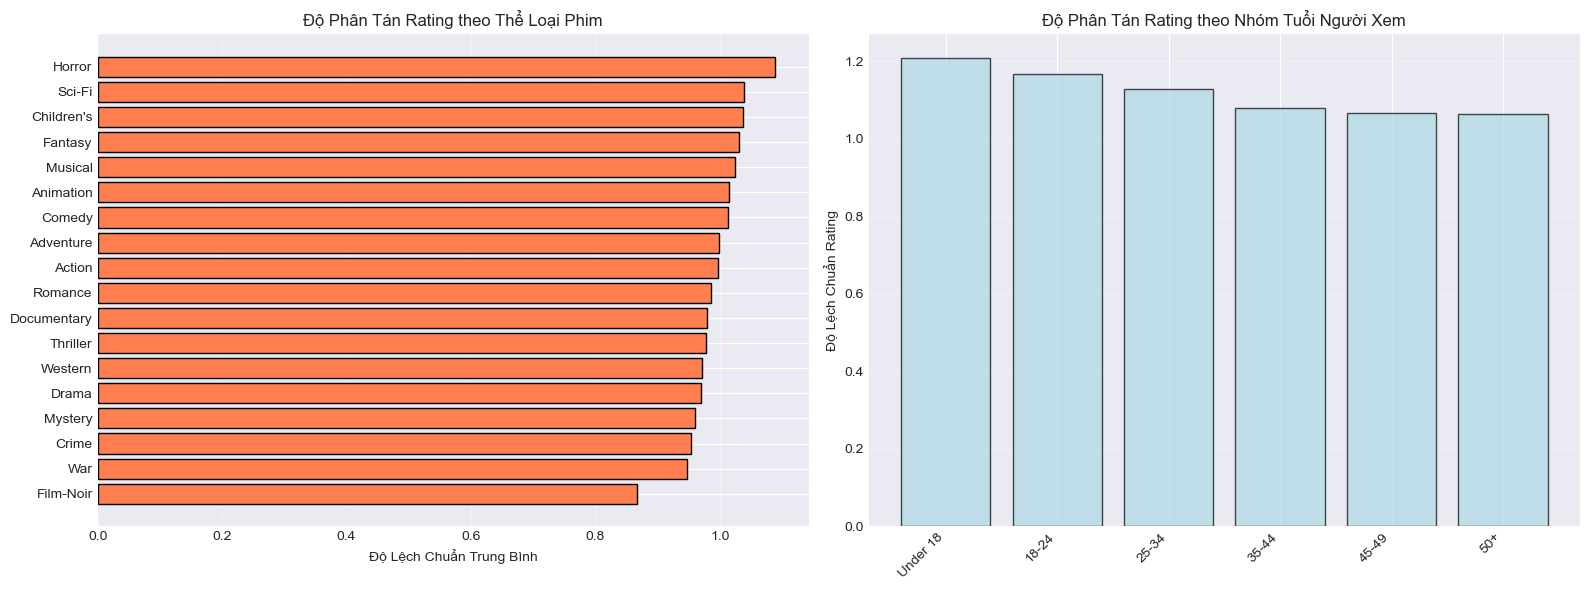

In [23]:
# Biểu đồ so sánh độ lệch chuẩn theo thể loại
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: Độ lệch chuẩn theo thể loại
genre_mean_std = genre_stats['mean_std'].sort_values(ascending=True)
axes[0].barh(range(len(genre_mean_std)), genre_mean_std.values, color='coral', edgecolor='black')
axes[0].set_yticks(range(len(genre_mean_std)))
axes[0].set_yticklabels(genre_mean_std.index)
axes[0].set_xlabel('Độ Lệch Chuẩn Trung Bình')
axes[0].set_title('Độ Phân Tán Rating theo Thể Loại Phim')
axes[0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 2: Độ lệch chuẩn theo nhóm tuổi
age_order = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50+']
age_group_stats_ordered = age_group_stats.reindex(age_order)
axes[1].bar(range(len(age_group_stats_ordered)), age_group_stats_ordered['std'].values, 
            color='lightblue', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(age_group_stats_ordered)))
axes[1].set_xticklabels(age_group_stats_ordered.index, rotation=45, ha='right')
axes[1].set_ylabel('Độ Lệch Chuẩn Rating')
axes[1].set_title('Độ Phân Tán Rating theo Nhóm Tuổi Người Xem')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('std_by_genre_and_age.png', dpi=100, bbox_inches='tight')
plt.show()

In [24]:
# Kiểm định ANOVA: Có khác biệt đáng kể không?
from scipy.stats import f_oneway, kruskal

# ANOVA cho thể loại
genre_groups = [group['std'].dropna().values for name, group in 
                genre_movie_stats_filtered.groupby('genres')]
f_stat_genre, p_value_genre = f_oneway(*genre_groups)

print("Kiểm định ANOVA cho độ lệch chuẩn theo thể loại:")
print(f"  F-statistic: {f_stat_genre:.4f}")
print(f"  P-value: {p_value_genre:.4e}")
print(f"  Kết luận: {'Có sự khác biệt đáng kể' if p_value_genre < 0.05 else 'Không có sự khác biệt'} (α=0.05)")

# ANOVA cho nhóm tuổi
age_groups = [group['rating'].dropna().values for name, group in 
              data.groupby('age_group')]
f_stat_age, p_value_age = f_oneway(*age_groups)

print("\nKiểm định ANOVA cho rating theo nhóm tuổi:")
print(f"  F-statistic: {f_stat_age:.4f}")
print(f"  P-value: {p_value_age:.4e}")
print(f"  Kết luận: {'Có sự khác biệt đáng kể' if p_value_age < 0.05 else 'Không có sự khác biệt'} (α=0.05)")

Kiểm định ANOVA cho độ lệch chuẩn theo thể loại:
  F-statistic: 25.5104
  P-value: 1.4213e-77
  Kết luận: Có sự khác biệt đáng kể (α=0.05)

Kiểm định ANOVA cho rating theo nhóm tuổi:
  F-statistic: 744.6583
  P-value: 0.0000e+00
  Kết luận: Có sự khác biệt đáng kể (α=0.05)


---

# Phần 2: Phân Tích Khám Phá - Tìm Nguyên Nhân Sự Phân Hóa

## 2.1 - Yếu tố ảnh hưởng đến độ phân tán rating

### Câu hỏi:
"Những yếu tố nào (thể loại, năm phát hành, giới tính người xem, tuổi, độ nổi tiếng) có ảnh hưởng đáng kể đến mức độ phân tán điểm đánh giá của phim?"

In [25]:
# Chuẩn bị dữ liệu cho ma trận tương quan
from sklearn.preprocessing import LabelEncoder

# Tính thống kê cho từng phim
movie_stats_simple = data_exploded.groupby('movie_id').agg({
    'rating': ['mean', 'std', 'count'],
    'release_year': 'first',
    'genres': 'first',
    'gender': lambda x: (x == 'M').sum() / len(x),  # tỷ lệ nam
    'age': 'mean'  # tuổi trung bình người xem
}).reset_index()

# Làm phẳng MultiIndex
movie_stats_simple.columns = ['movie_id', 'mean_rating', 'std_rating', 'num_ratings', 'release_year', 'primary_genre', 'male_ratio', 'avg_viewer_age']

# Encode thể loại
le_genre = LabelEncoder()
movie_stats_simple['genre_num'] = le_genre.fit_transform(movie_stats_simple['primary_genre'])

# Chọn các cột cần thiết
corr_matrix_data = movie_stats_simple[[
    'std_rating',        # độ phân tán rating (biến đích)
    'genre_num',         # thể loại (encoded)
    'release_year',      # năm phát hành
    'male_ratio',        # tỷ lệ nam người xem
    'avg_viewer_age',    # tuổi trung bình người xem
    'num_ratings'        # độ nổi tiếng (số lượt đánh giá)
]].dropna()

# Đổi tên cột cho dễ đọc
corr_matrix_data.columns = ['Std Rating', 'Genre', 'Release Year', 'Male Ratio', 'Avg Age', 'Popularity']

# Tính ma trận tương quan
correlation_matrix = corr_matrix_data.corr()

print("="*70)
print("MA TRẬN TƯƠNG QUAN: Các Yếu Tố vs Độ Phân Tán Rating")
print("="*70)
print(correlation_matrix.round(3))
print("\n")

# Trích xuất tương quan với Std Rating
corr_with_std = correlation_matrix['Std Rating'].drop('Std Rating').sort_values(key=abs, ascending=False)
print("Tương Quan với Độ Phân Tán Rating (sắp xếp theo độ mạnh):")
print("-"*70)
for factor, corr_val in corr_with_std.items():
    print(f"  {factor:15s}: {corr_val:7.4f}")

MA TRẬN TƯƠNG QUAN: Các Yếu Tố vs Độ Phân Tán Rating
              Std Rating  Genre  Release Year  Male Ratio  Avg Age  Popularity
Std Rating         1.000  0.023         0.089       0.072   -0.143      -0.072
Genre              0.023  1.000        -0.142      -0.058    0.229      -0.288
Release Year       0.089 -0.142         1.000      -0.083   -0.512       0.020
Male Ratio         0.072 -0.058        -0.083       1.000   -0.018       0.069
Avg Age           -0.143  0.229        -0.512      -0.018    1.000      -0.093
Popularity        -0.072 -0.288         0.020       0.069   -0.093       1.000


Tương Quan với Độ Phân Tán Rating (sắp xếp theo độ mạnh):
----------------------------------------------------------------------
  Avg Age        : -0.1431
  Release Year   :  0.0886
  Popularity     : -0.0724
  Male Ratio     :  0.0720
  Genre          :  0.0230


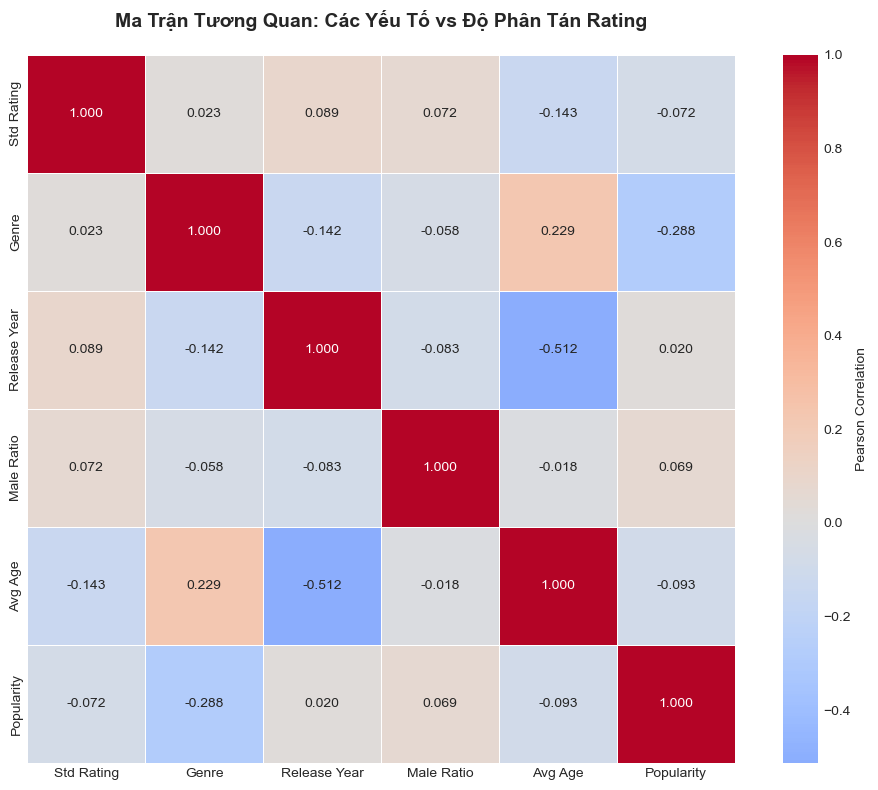


Heatmap đã lưu: correlation_matrix_factors.png


In [26]:
# Vẽ heatmap ma trận tương quan
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0, 
            square=True, 
            linewidths=0.5,
            cbar_kws={'label': 'Pearson Correlation'},
            ax=ax)

ax.set_title('Ma Trận Tương Quan: Các Yếu Tố vs Độ Phân Tán Rating', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('correlation_matrix_factors.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nHeatmap đã lưu: correlation_matrix_factors.png")


## 2.2 - Thể loại phim cực đoan vs thể loại chính thống

### Câu hỏi:
"Liệu các thể loại phim cực đoan (kinh dị, tâm lý, chính trị) có xu hướng có độ lệch chuẩn rating cao hơn so với phim tình cảm, hài hay không?"

In [27]:
# Phân loại thể loại thành cực đoan vs chính thống
extreme_genres = ['Horror', 'Thriller', 'War']
mainstream_genres = ['Romance', 'Comedy', 'Adventure']

def categorize_genre(genre):
    if genre in extreme_genres:
        return 'Extreme'
    elif genre in mainstream_genres:
        return 'Mainstream'
    else:
        return 'Other'

data_exploded['genre_category'] = data_exploded['genres'].apply(categorize_genre)

# Tính thống kê cho mỗi phim-thể loại-danh mục
genre_category_stats = data_exploded.groupby(['genres', 'genre_category', 'title'])['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std')
]).reset_index()

# Làm phẳng MultiIndex columns
genre_category_stats.columns = ['genres', 'genre_category', 'title', 'count', 'mean', 'std']
genre_category_stats = genre_category_stats[genre_category_stats['count'] >= 50]

# Tính trung bình cho mỗi danh mục
category_avg = genre_category_stats.groupby('genre_category')['std'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)

print("Độ lệch chuẩn theo danh mục thể loại:")
print(category_avg)

# Kiểm định t-test giữa Extreme và Mainstream
extreme_std = genre_category_stats[genre_category_stats['genre_category'] == 'Extreme']['std'].dropna()
mainstream_std = genre_category_stats[genre_category_stats['genre_category'] == 'Mainstream']['std'].dropna()

from scipy.stats import ttest_ind
t_stat, p_value_ttest = ttest_ind(extreme_std, mainstream_std)

print(f"\nKiểm định t-test (Extreme vs Mainstream):")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value_ttest:.4e}")
print(f"  Extreme mean std: {extreme_std.mean():.4f}")
print(f"  Mainstream mean std: {mainstream_std.mean():.4f}")
print(f"  Kết luận: {'Phim cực đoan có độ phân tán cao hơn' if t_stat > 0 and p_value_ttest < 0.05 else 'Không có sự khác biệt đáng kể'}")

Độ lệch chuẩn theo danh mục thể loại:
                    mean    median       std  count
genre_category                                     
Extreme         1.008833  1.005667  0.125940    750
Mainstream      1.004335  0.998142  0.110006   1415
Other           0.990317  0.987906  0.114047   2398

Kiểm định t-test (Extreme vs Mainstream):
  T-statistic: 0.8603
  P-value: 3.8972e-01
  Extreme mean std: 1.0088
  Mainstream mean std: 1.0043
  Kết luận: Không có sự khác biệt đáng kể


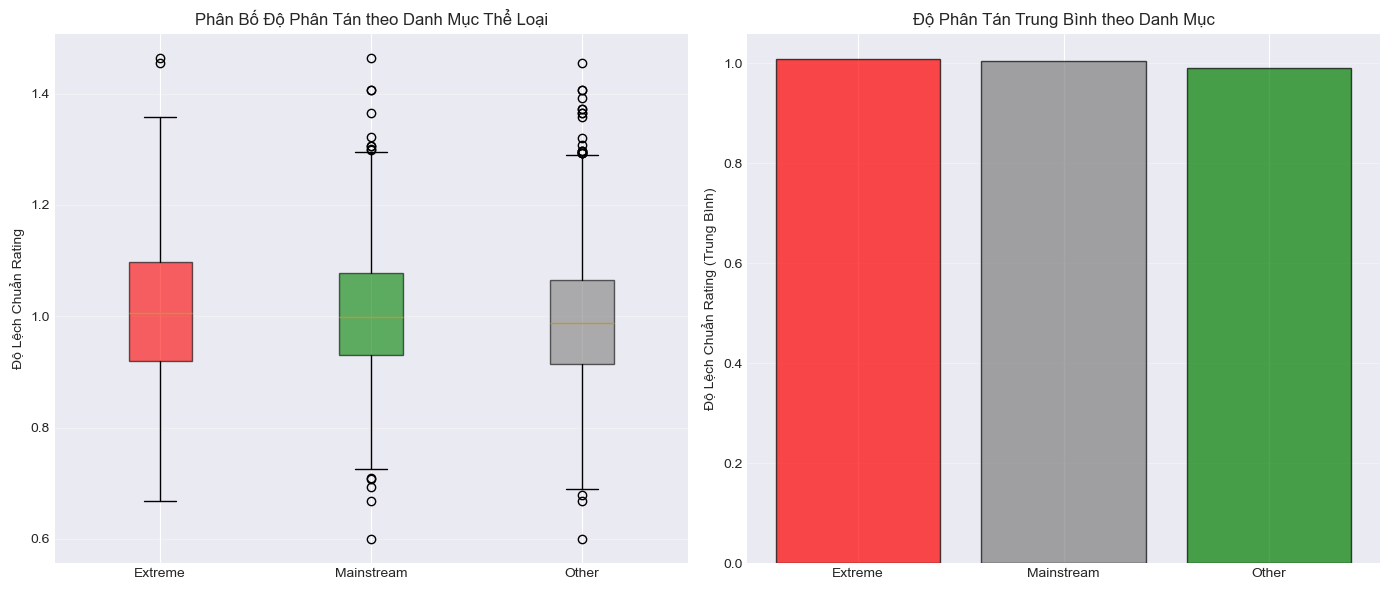

In [28]:
# Biểu đồ so sánh thể loại cực đoan vs chính thống
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Biểu đồ 1: Box plot
data_for_boxplot = [
    genre_category_stats[genre_category_stats['genre_category'] == 'Extreme']['std'].dropna(),
    genre_category_stats[genre_category_stats['genre_category'] == 'Mainstream']['std'].dropna(),
    genre_category_stats[genre_category_stats['genre_category'] == 'Other']['std'].dropna()
]
bp = axes[0].boxplot(data_for_boxplot, labels=['Extreme', 'Mainstream', 'Other'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['red', 'green', 'gray']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0].set_ylabel('Độ Lệch Chuẩn Rating')
axes[0].set_title('Phân Bố Độ Phân Tán theo Danh Mục Thể Loại')
axes[0].grid(True, alpha=0.3, axis='y')

# Biểu đồ 2: Bar plot
category_avg_sorted = category_avg.sort_values('mean', ascending=False)
axes[1].bar(range(len(category_avg_sorted)), category_avg_sorted['mean'].values, 
            color=['red', 'gray', 'green'], alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(category_avg_sorted)))
axes[1].set_xticklabels(category_avg_sorted.index)
axes[1].set_ylabel('Độ Lệch Chuẩn Rating (Trung Bình)')
axes[1].set_title('Độ Phân Tán Trung Bình theo Danh Mục')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('genre_category_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

## 2.3 - Mối tương quan: Độ phổ biến vs Mức độ đồng thuận

### Câu hỏi:
"Có mối tương quan giữa độ phổ biến (số lượt rating) và mức độ đồng thuận (σ) của người xem không?"

In [30]:
# Tương quan giữa số lượng ratings và độ lệch chuẩn
correlation = movie_stats_simple['num_ratings'].corr(movie_stats_simple['std_rating'])
print(f"Tương quan Pearson (Số ratings vs Std rating): {correlation:.4f}")

# Kiểm định thống kê cho tương quan
from scipy.stats import pearsonr
r_coef, p_value_corr = pearsonr(movie_stats_simple['num_ratings'], movie_stats_simple['std_rating'])
print(f"P-value: {p_value_corr:.4e}")
print(f"Kết luận: {'Có mối tương quan đáng kể' if p_value_corr < 0.05 else 'Không có mối tương quan'}")

# Phân loại phim theo độ phổ biến
def popularity_level(count):
    if count < 250:
        return 'Low'
    elif count < 500:
        return 'Medium'
    elif count < 1000:
        return 'High'
    else:
        return 'Very High'

movie_stats_simple['popularity'] = movie_stats_simple['num_ratings'].apply(popularity_level)

popularity_stats = movie_stats_simple.groupby('popularity')['std_rating'].agg(['count', 'mean', 'median', 'std'])
print("\nĐộ lệch chuẩn theo mức độ phổ biến:")
print(popularity_stats)

Tương quan Pearson (Số ratings vs Std rating): -0.0724
P-value: nan
Kết luận: Không có mối tương quan

Độ lệch chuẩn theo mức độ phổ biến:
            count      mean    median       std
popularity                                     
High          440  0.982922  0.979205  0.101977
Low          2039  1.015215  1.022951  0.279133
Medium        552  0.993773  0.984581  0.119198
Very High     588  0.967642  0.964378  0.108029


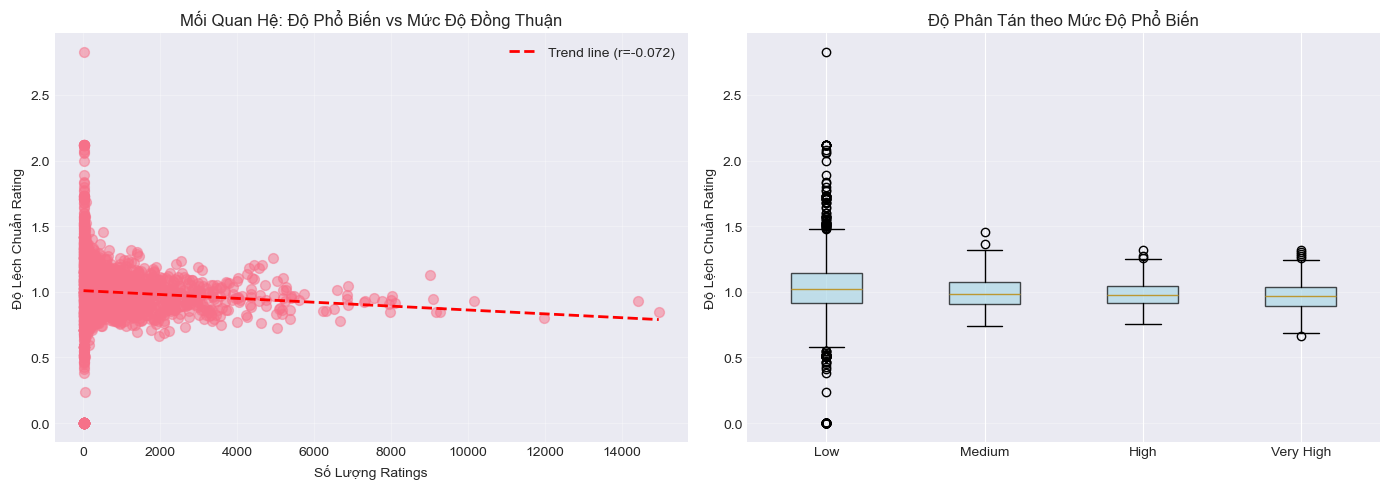

In [33]:
# Biểu đồ mối tương quan: Số ratings vs Std rating
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ scatter với trendline
# Loại bỏ NaN trước khi vẽ
clean_data = movie_stats_simple[['num_ratings', 'std_rating']].dropna()
axes[0].scatter(clean_data['num_ratings'], clean_data['std_rating'], alpha=0.5, s=50)
z = np.polyfit(clean_data['num_ratings'], clean_data['std_rating'], 1)
p = np.poly1d(z)
x_line = np.linspace(clean_data['num_ratings'].min(), clean_data['num_ratings'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label=f"Trend line (r={correlation:.3f})")
axes[0].set_xlabel('Số Lượng Ratings')
axes[0].set_ylabel('Độ Lệch Chuẩn Rating')
axes[0].set_title('Mối Quan Hệ: Độ Phổ Biến vs Mức Độ Đồng Thuận')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Biểu đồ box plot theo mức độ phổ biến
popularity_order = ['Low', 'Medium', 'High', 'Very High']
data_for_popularity_boxplot = [
    movie_stats_simple[movie_stats_simple['popularity'] == pop]['std_rating'].dropna()
    for pop in popularity_order
]
bp2 = axes[1].boxplot(data_for_popularity_boxplot, labels=popularity_order, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
axes[1].set_ylabel('Độ Lệch Chuẩn Rating')
axes[1].set_title('Độ Phân Tán theo Mức Độ Phổ Biến')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('popularity_vs_std.png', dpi=100, bbox_inches='tight')
plt.show()

---

# Phần 3: Phân Tích Dự Đoán - Mô Hình Dự Báo Độ Phân Hóa

## 3.1 - Xây dựng mô hình dự đoán độ lệch chuẩn rating

### Câu hỏi:
"Có thể dự đoán độ lệch chuẩn rating của một phim dựa trên các đặc trưng như thể loại, năm phát hành, số lượng người xem và điểm trung bình không?"

In [34]:
# Chuẩn bị dữ liệu cho mô hình
# Tính độ lệch chuẩn cho mỗi phim-thể loại
model_data = data_exploded.groupby(['title', 'genres']).agg({
    'rating': ['std', 'mean', 'count'],
    'release_year': 'first',
    'age': 'mean',
    'gender': lambda x: (x == 'M').sum() / len(x)  # tỷ lệ nam giới
}).reset_index()

model_data.columns = ['title', 'genre', 'std_rating', 'mean_rating', 'num_ratings', 'release_year', 'avg_age', 'male_ratio']

# Lọc dữ liệu có ít nhất 30 ratings
model_data = model_data[model_data['num_ratings'] >= 30].copy()

# Mã hóa thể loại
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
model_data['genre_encoded'] = le.fit_transform(model_data['genre'])

# Tính thập niên
model_data['decade'] = (model_data['release_year'] // 10) * 10

print(f"Dữ liệu cho mô hình: {model_data.shape}")
print(model_data.head(10))

Dữ liệu cho mô hình: (5042, 10)
                                title       genre  std_rating  mean_rating  \
0              $1,000,000 Duck (1971)  Children's    1.092563     3.027027   
1              $1,000,000 Duck (1971)      Comedy    1.092563     3.027027   
2                'Night Mother (1986)       Drama    1.118636     3.371429   
3           'Til There Was You (1997)       Drama    1.020159     2.692308   
4           'Til There Was You (1997)     Romance    1.020159     2.692308   
5                  'burbs, The (1989)      Comedy    1.107760     2.910891   
6       ...And Justice for All (1979)       Drama    0.878110     3.713568   
7       ...And Justice for All (1979)    Thriller    0.878110     3.713568   
9   10 Things I Hate About You (1999)      Comedy    0.989815     3.422857   
10  10 Things I Hate About You (1999)     Romance    0.989815     3.422857   

    num_ratings  release_year    avg_age  male_ratio  genre_encoded  decade  
0            37          1971  

In [35]:
# Xây dựng mô hình Random Forest
# Đặc trưng đầu vào
X = model_data[['genre_encoded', 'mean_rating', 'num_ratings', 'release_year', 'avg_age', 'male_ratio']]
y = model_data['std_rating']

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Huấn luyện mô hình
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Dự đoán
y_pred = rf_model.predict(X_test_scaled)

# Đánh giá mô hình
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))

print("Kết quả mô hình Random Forest:")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")

# Tầm quan trọng các đặc trưng
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTầm quan trọng các đặc trưng:")
print(feature_importance)

Kết quả mô hình Random Forest:
  R² Score: 0.5995
  RMSE: 0.0768
  MAE: 0.0526

Tầm quan trọng các đặc trưng:
         feature  importance
1    mean_rating    0.469675
4        avg_age    0.165420
2    num_ratings    0.138845
5     male_ratio    0.109621
3   release_year    0.091694
0  genre_encoded    0.024745


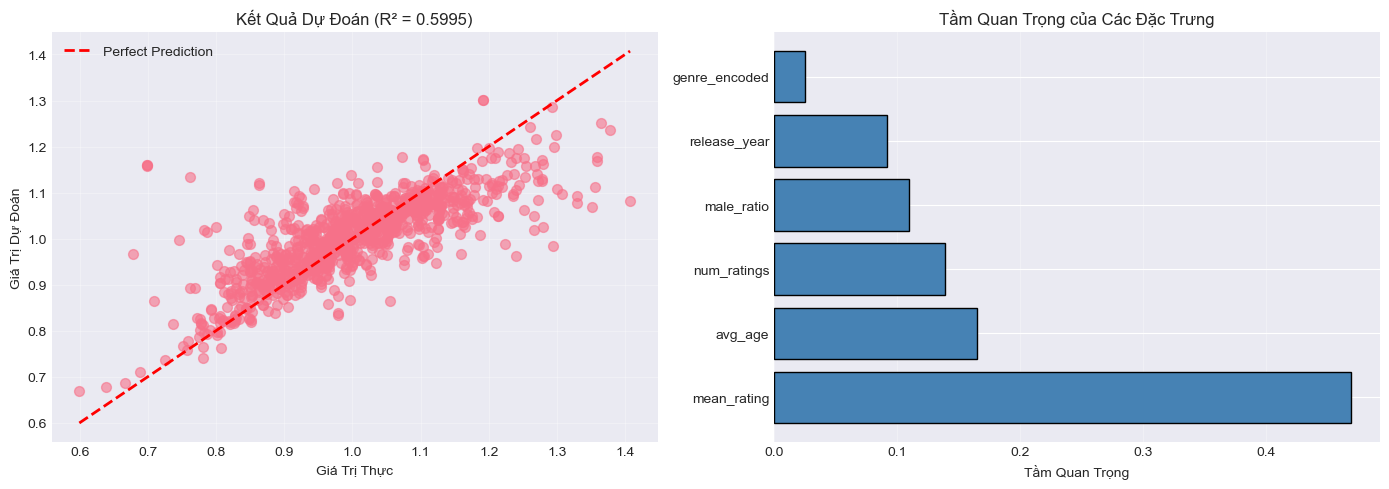

In [36]:
# Biểu đồ kết quả mô hình
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: Giá trị thực vs Dự đoán
axes[0].scatter(y_test, y_pred, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Giá Trị Thực')
axes[0].set_ylabel('Giá Trị Dự Đoán')
axes[0].set_title(f'Kết Quả Dự Đoán (R² = {r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Biểu đồ 2: Tầm quan trọng đặc trưng
axes[1].barh(range(len(feature_importance)), feature_importance['importance'].values, color='steelblue', edgecolor='black')
axes[1].set_yticks(range(len(feature_importance)))
axes[1].set_yticklabels(feature_importance['feature'].values)
axes[1].set_xlabel('Tầm Quan Trọng')
axes[1].set_title('Tầm Quan Trọng của Các Đặc Trưng')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('prediction_model.png', dpi=100, bbox_inches='tight')
plt.show()

## 3.2 - Độ lệch chuẩn cao như chỉ báo "controversial" 

### Câu hỏi:
"Mức độ phân tán rating có thể được sử dụng làm chỉ báo cho tính 'controversial' của nội dung trong hệ thống gợi ý phim không?"

In [39]:
# Phân loại phim theo mức độ "controversial"
q75 = movie_stats_simple['std_rating'].quantile(0.75)
q50 = movie_stats_simple['std_rating'].quantile(0.50)
q25 = movie_stats_simple['std_rating'].quantile(0.25)

def controversial_level(std):
    if std >= q75:
        return 'Very Controversial'
    elif std >= q50:
        return 'Somewhat Controversial'
    elif std >= q25:
        return 'Low Controversy'
    else:
        return 'Consensus'

movie_stats_simple['controversy_level'] = movie_stats_simple['std_rating'].apply(controversial_level)

controversy_dist = movie_stats_simple['controversy_level'].value_counts()
print("Phân bố phim theo mức độ controversial:")
print(controversy_dist)

# Phân tích đặc điểm của các nhóm
print("\nĐặc điểm của mỗi nhóm controversial:")
for level in ['Consensus', 'Low Controversy', 'Somewhat Controversial', 'Very Controversial']:
    subset = movie_stats_simple[movie_stats_simple['controversy_level'] == level]
    print(f"\n{level}:")
    print(f"  Số phim: {len(subset)}")
    print(f"  Độ lệch chuẩn trung bình: {subset['std_rating'].mean():.4f}")
    print(f"  Rating trung bình: {subset['mean_rating'].mean():.4f}")
    print(f"  Số ratings trung bình: {subset['num_ratings'].mean():.0f}")
    print(f"  Năm phát hành trung bình: {subset['release_year'].mean():.0f}")

Phân bố phim theo mức độ controversial:
controversy_level
Consensus                 992
Somewhat Controversial    905
Very Controversial        905
Low Controversy           904
Name: count, dtype: int64

Đặc điểm của mỗi nhóm controversial:

Consensus:
  Số phim: 992
  Độ lệch chuẩn trung bình: 0.7629
  Rating trung bình: 3.4781
  Số ratings trung bình: 608
  Năm phát hành trung bình: 1982

Low Controversy:
  Số phim: 904
  Độ lệch chuẩn trung bình: 0.9551
  Rating trung bình: 3.3692
  Số ratings trung bình: 803
  Năm phát hành trung bình: 1986

Somewhat Controversial:
  Số phim: 905
  Độ lệch chuẩn trung bình: 1.0458
  Rating trung bình: 3.1034
  Số ratings trung bình: 561
  Năm phát hành trung bình: 1989

Very Controversial:
  Số phim: 905
  Độ lệch chuẩn trung bình: 1.2373
  Rating trung bình: 2.9820
  Số ratings trung bình: 293
  Năm phát hành trung bình: 1988


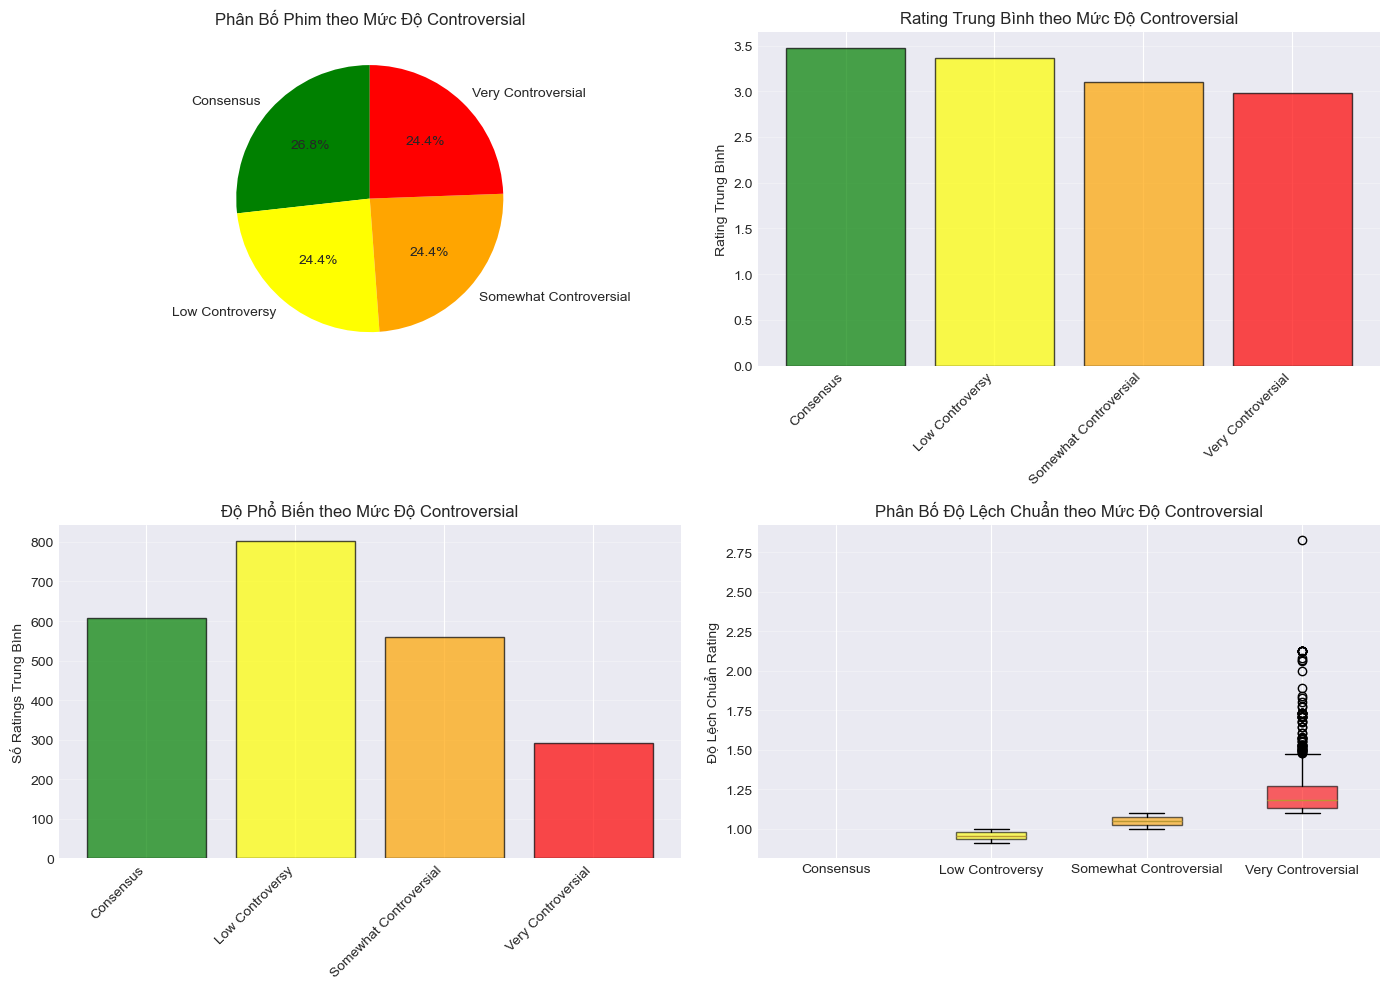

In [42]:
# Biểu đồ phân bố mức độ controversial
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Biểu đồ 1: Pie chart
controversy_levels_order = ['Consensus', 'Low Controversy', 'Somewhat Controversial', 'Very Controversial']
controversy_counts = [movie_stats_simple[movie_stats_simple['controversy_level'] == level].shape[0] 
                      for level in controversy_levels_order]
colors = ['green', 'yellow', 'orange', 'red']
axes[0, 0].pie(controversy_counts, labels=controversy_levels_order, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 0].set_title('Phân Bố Phim theo Mức Độ Controversial')

# Biểu đồ 2: Rating trung bình theo mức độ controversial
controversy_mean_ratings = [movie_stats_simple[movie_stats_simple['controversy_level'] == level]['mean_rating'].mean() 
                            for level in controversy_levels_order]
axes[0, 1].bar(range(len(controversy_levels_order)), controversy_mean_ratings, 
               color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(len(controversy_levels_order)))
axes[0, 1].set_xticklabels(controversy_levels_order, rotation=45, ha='right')
axes[0, 1].set_ylabel('Rating Trung Bình')
axes[0, 1].set_title('Rating Trung Bình theo Mức Độ Controversial')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Biểu đồ 3: Số ratings theo mức độ controversial
controversy_num_ratings = [movie_stats_simple[movie_stats_simple['controversy_level'] == level]['num_ratings'].mean() 
                           for level in controversy_levels_order]
axes[1, 0].bar(range(len(controversy_levels_order)), controversy_num_ratings, 
               color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(controversy_levels_order)))
axes[1, 0].set_xticklabels(controversy_levels_order, rotation=45, ha='right')
axes[1, 0].set_ylabel('Số Ratings Trung Bình')
axes[1, 0].set_title('Độ Phổ Biến theo Mức Độ Controversial')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Biểu đồ 4: Box plot std rating
data_box = [movie_stats_simple[movie_stats_simple['controversy_level'] == level]['std_rating'].values 
            for level in controversy_levels_order]
bp = axes[1, 1].boxplot(data_box, labels=controversy_levels_order, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[1, 1].set_ylabel('Độ Lệch Chuẩn Rating')
axes[1, 1].set_title('Phân Bố Độ Lệch Chuẩn theo Mức Độ Controversial')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('controversy_levels.png', dpi=100, bbox_inches='tight')
plt.show()

## 3.3 - Hiệu suất thuật toán trên phim high-std

### Câu hỏi:
"Liệu các thuật toán gợi ý dựa trên trung bình có hoạt động kém hơn trên các phim có độ lệch chuẩn rating cao không?"

In [45]:
# Phân loại phim theo độ phân tán: cao vs thấp
median_std = movie_stats_simple['std_rating'].median()
movie_stats_simple['std_category'] = movie_stats_simple['std_rating'].apply(
    lambda x: 'High Std' if x >= median_std else 'Low Std'
)

# Với giả định rằng "mean-based recommendation" sử dụng mean rating
# Tính sai lệch từ mean (càng cao = recommendation kém)
data_with_features = data.merge(
    movie_stats_simple[['movie_id', 'std_rating', 'std_category', 'mean_rating']],
    on='movie_id',
    how='left'
)

# Tính độ lệch từ mean rating
data_with_features['deviation_from_mean'] = np.abs(data_with_features['rating'] - data_with_features['mean_rating'])

# Tính MAE của mean-based recommendation cho mỗi nhóm
mae_by_std = data_with_features.groupby('std_category')['deviation_from_mean'].agg(['mean', 'std', 'count'])

print("Hiệu suất Mean-based Recommendation:")
print(mae_by_std)

# Kiểm định t-test
high_std_deviations = data_with_features[data_with_features['std_category'] == 'High Std']['deviation_from_mean']
low_std_deviations = data_with_features[data_with_features['std_category'] == 'Low Std']['deviation_from_mean']

t_stat_rec, p_value_rec = ttest_ind(high_std_deviations, low_std_deviations)
print(f"\nKiểm định t-test (hiệu suất trên High Std vs Low Std):")
print(f"  T-statistic: {t_stat_rec:.4f}")
print(f"  P-value: {p_value_rec:.4e}")
print(f"  Mean-based recommendation kém hơn trên phim high-std: {t_stat_rec > 0 and p_value_rec < 0.05}")

Hiệu suất Mean-based Recommendation:
                  mean       std   count
std_category                            
High Std      0.886664  0.630238  366699
Low Std       0.716349  0.549418  633510

Kiểm định t-test (hiệu suất trên High Std vs Low Std):
  T-statistic: 141.4310
  P-value: 0.0000e+00
  Mean-based recommendation kém hơn trên phim high-std: True


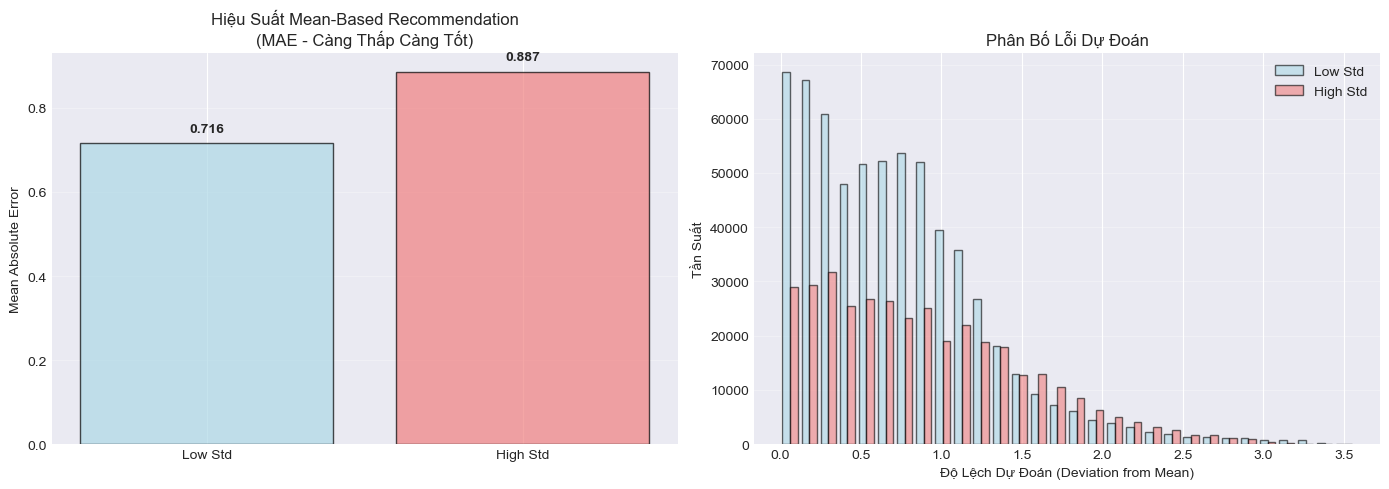

In [46]:
# Biểu đồ hiệu suất recommendation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: MAE so sánh
std_categories = ['Low Std', 'High Std']
mae_values = [
    data_with_features[data_with_features['std_category'] == cat]['deviation_from_mean'].mean()
    for cat in std_categories
]
colors_rec = ['lightblue', 'lightcoral']
axes[0].bar(std_categories, mae_values, color=colors_rec, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_title('Hiệu Suất Mean-Based Recommendation\n(MAE - Càng Thấp Càng Tốt)')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Biểu đồ 2: Phân bố lỗi dự đoán
data_low_std = data_with_features[data_with_features['std_category'] == 'Low Std']['deviation_from_mean']
data_high_std = data_with_features[data_with_features['std_category'] == 'High Std']['deviation_from_mean']

axes[1].hist([data_low_std, data_high_std], bins=30, label=['Low Std', 'High Std'], 
             color=colors_rec, alpha=0.6, edgecolor='black')
axes[1].set_xlabel('Độ Lệch Dự Đoán (Deviation from Mean)')
axes[1].set_ylabel('Tần Suất')
axes[1].set_title('Phân Bố Lỗi Dự Đoán')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('recommendation_performance.png', dpi=100, bbox_inches='tight')
plt.show()

---

# Phần 4: Phân Tích So Sánh - So Sánh Giữa Các Nhóm

## 4.1 - Bất đồng ý kiến giữa giới tính

### Câu hỏi:
"Giữa các nhóm giới tính người dùng, phim nào có mức độ bất đồng ý kiến lớn nhất?"

In [47]:
# Tính độ lệch chuẩn rating theo phim và giới tính
gender_movie_stats = data.groupby(['title', 'gender'])['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std')
]).reset_index()

# Lọc phim có ít nhất 50 ratings từ mỗi giới tính
gender_movie_stats_filtered = gender_movie_stats[gender_movie_stats['count'] >= 50].copy()

# Tính hiệu điểm đánh giá trung bình giữa nam và nữ
gender_diff = data.groupby('title')['rating'].apply(
    lambda x: np.abs(x[data.loc[x.index, 'gender'] == 'M'].mean() - 
                     x[data.loc[x.index, 'gender'] == 'F'].mean())
).reset_index()
gender_diff.columns = ['title', 'gender_rating_diff']

# Lọc các phim có đủ dữ liệu cho cả hai giới
gender_diff_filtered = gender_diff[gender_diff['gender_rating_diff'].notna()].copy()
gender_diff_filtered = gender_diff_filtered.sort_values('gender_rating_diff', ascending=False)

print("Top 20 phim có bất đồng ý kiến lớn nhất giữa nam và nữ:")
print(gender_diff_filtered.head(20).to_string(index=False))

Top 20 phim có bất đồng ý kiến lớn nhất giữa nam và nữ:
                                                      title  gender_rating_diff
                 Tigrero: A Film That Was Never Made (1994)            3.333333
                                        Country Life (1994)            3.000000
Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919)            3.000000
                               James Dean Story, The (1957)            3.000000
                                     Neon Bible, The (1995)            3.000000
                                           Enfer, L' (1994)            2.750000
                                           Babyfever (1994)            2.666667
                                          Stalingrad (1993)            2.593750
                                   Woman of Paris, A (1923)            2.571429
                                               Cobra (1925)            2.500000
                         Killer: A Journal of Murder (1995)     

## 4.2 - Độ lệch chuẩn rating theo thập niên

### Câu hỏi:
"So sánh độ lệch chuẩn trung bình giữa các thập niên sản xuất phim (1990s, 2000s, 2010s): liệu phim hiện đại có xu hướng 'polarizing' hơn phim cũ không?"

In [48]:
# Tạo cột decade trong data
data['decade'] = (data['release_year'] // 10) * 10

# Tính thống kê theo thập niên
decade_stats = data.groupby('decade')['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std')
]).reset_index()
decade_stats.columns = ['decade', 'num_ratings', 'mean_rating', 'std_rating']
decade_stats = decade_stats.sort_values('decade')

print("Độ lệch chuẩn rating theo thập niên:")
print(decade_stats.to_string(index=False))

# Kiểm định ANOVA giữa các thập niên
decade_groups = [group['rating'].values for name, group in data.groupby('decade')]
f_stat_decade, p_value_decade = f_oneway(*decade_groups)

print(f"\nKiểm định ANOVA cho độ lệch chuẩn rating theo thập niên:")
print(f"  F-statistic: {f_stat_decade:.4f}")
print(f"  P-value: {p_value_decade:.4e}")
print(f"  Kết luận: {'Phim hiện đại có xu hướng polarizing hơn' if p_value_decade < 0.05 else 'Không có sự khác biệt'}")

Độ lệch chuẩn rating theo thập niên:
 decade  num_ratings  mean_rating  std_rating
   1910           45     3.466667    1.035725
   1920         1696     3.999410    1.057352
   1930        12729     4.022076    0.970446
   1940        21501     4.051160    0.957218
   1950        35232     3.959469    0.984425
   1960        48555     3.918113    0.984604
   1970        82552     3.831742    1.049656
   1980       224056     3.594999    1.092320
   1990       532843     3.466730    1.136347
   2000        41000     3.373341    1.157664

Kiểm định ANOVA cho độ lệch chuẩn rating theo thập niên:
  F-statistic: 2928.8954
  P-value: 0.0000e+00
  Kết luận: Phim hiện đại có xu hướng polarizing hơn


## 4.3 - Hành vi đánh giá của nhóm tuổi trẻ vs lớn tuổi

### Câu hỏi:
"Người dùng trẻ tuổi (dưới 25) có xu hướng đánh giá cực đoan (1 hoặc 5) hơn so với nhóm lớn tuổi không?"

In [49]:
# Phân loại đánh giá cực đoan (1 hoặc 5)
data['is_extreme_rating'] = data['rating'].isin([1, 5]).astype(int)

# Tính tỷ lệ đánh giá cực đoan theo nhóm tuổi
age_extreme_ratings = data.groupby('age_group').agg({
    'is_extreme_rating': ['sum', 'count']
}).reset_index()
age_extreme_ratings.columns = ['age_group', 'extreme_count', 'total_count']
age_extreme_ratings['extreme_ratio'] = age_extreme_ratings['extreme_count'] / age_extreme_ratings['total_count']
age_extreme_ratings = age_extreme_ratings.sort_values('extreme_ratio', ascending=False)

print("Tỷ lệ đánh giá cực đoan theo nhóm tuổi:")
print(age_extreme_ratings.to_string(index=False))

# Kiểm định chi-squared: độc lập giữa nhóm tuổi và hành vi đánh giá cực đoan
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(data['age_group'], data['is_extreme_rating'])
chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nKiểm định Chi-squared:")
print(f"  Chi-squared statistic: {chi2:.4f}")
print(f"  P-value: {p_value_chi2:.4e}")
print(f"  Kết luận: {'Nhóm tuổi trẻ có xu hướng đánh giá cực đoan hơn' if p_value_chi2 < 0.05 else 'Không có sự khác biệt'}")

Tỷ lệ đánh giá cực đoan theo nhóm tuổi:
age_group  extreme_count  total_count  extreme_ratio
 Under 18           9040        27211       0.332219
      50+          33867       111270       0.304368
    18-24          53621       183536       0.292155
    25-34         109628       395556       0.277149
    35-44          53777       199003       0.270232
    45-49          22551        83633       0.269642

Kiểm định Chi-squared:
  Chi-squared statistic: 950.7451
  P-value: 2.7645e-203
  Kết luận: Nhóm tuổi trẻ có xu hướng đánh giá cực đoan hơn


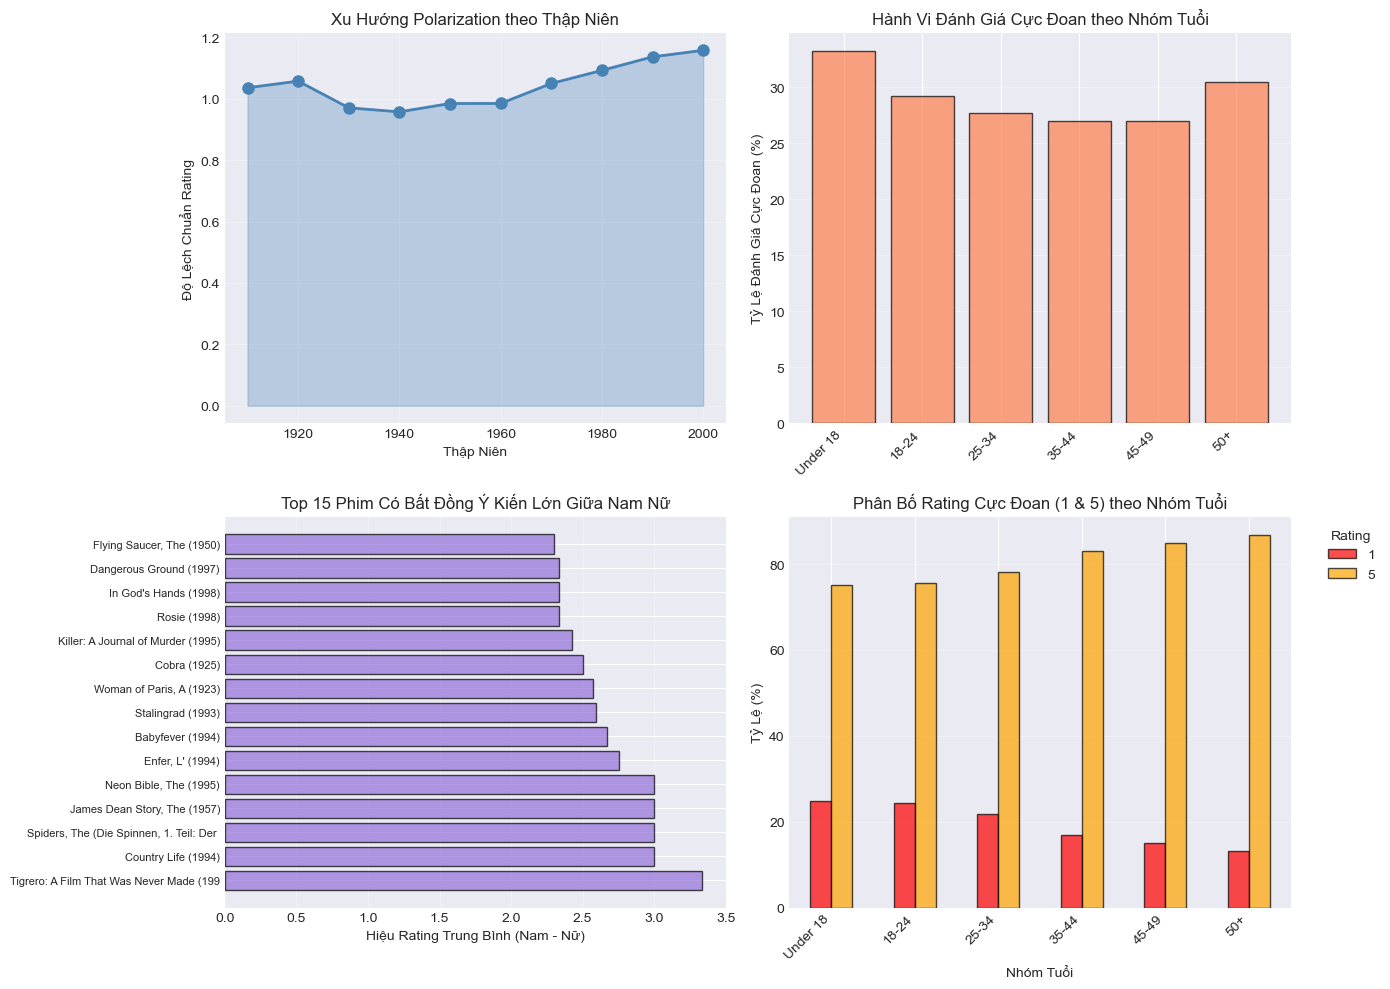

In [50]:
# Biểu đồ phân tích so sánh
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Biểu đồ 1: Độ lệch chuẩn theo thập niên
axes[0, 0].plot(decade_stats['decade'], decade_stats['std_rating'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].fill_between(decade_stats['decade'], decade_stats['std_rating'], alpha=0.3, color='steelblue')
axes[0, 0].set_xlabel('Thập Niên')
axes[0, 0].set_ylabel('Độ Lệch Chuẩn Rating')
axes[0, 0].set_title('Xu Hướng Polarization theo Thập Niên')
axes[0, 0].grid(True, alpha=0.3)

# Biểu đồ 2: Tỷ lệ đánh giá cực đoan theo nhóm tuổi
age_order_extreme = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50+']
age_extreme_sorted = age_extreme_ratings.set_index('age_group').reindex(age_order_extreme)
axes[0, 1].bar(range(len(age_extreme_sorted)), age_extreme_sorted['extreme_ratio'].values * 100, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(len(age_extreme_sorted)))
axes[0, 1].set_xticklabels(age_extreme_sorted.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Tỷ Lệ Đánh Giá Cực Đoan (%)')
axes[0, 1].set_title('Hành Vi Đánh Giá Cực Đoan theo Nhóm Tuổi')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Biểu đồ 3: Bất đồng ý kiến giữa nam và nữ (Top 15 phim)
top_gender_diff = gender_diff_filtered.head(15)
axes[1, 0].barh(range(len(top_gender_diff)), top_gender_diff['gender_rating_diff'].values, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_gender_diff)))
axes[1, 0].set_yticklabels([title[:40] for title in top_gender_diff['title'].values], fontsize=8)
axes[1, 0].set_xlabel('Hiệu Rating Trung Bình (Nam - Nữ)')
axes[1, 0].set_title('Top 15 Phim Có Bất Đồng Ý Kiến Lớn Giữa Nam Nữ')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 4: Phân bố rating theo độ cực đoan
rating_dist_extreme = data[data['is_extreme_rating'] == 1].groupby(['age_group', 'rating']).size().unstack(fill_value=0)
rating_dist_extreme_norm = rating_dist_extreme.div(rating_dist_extreme.sum(axis=1), axis=0) * 100

rating_dist_extreme_norm.reindex(age_order_extreme).plot(kind='bar', ax=axes[1, 1], color=['red', 'orange', 'yellow', 'lightgreen', 'lightblue', 'purple'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Nhóm Tuổi')
axes[1, 1].set_ylabel('Tỷ Lệ (%)')
axes[1, 1].set_title('Phân Bố Rating Cực Đoan (1 & 5) theo Nhóm Tuổi')
axes[1, 1].legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparative_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

---

# Phần 5: Phân Tích Mở Rộng - Liên Hệ Tâm Lý & Ứng Dụng Thực Tế

## 5.1 - Phân cực cảm xúc trong khán giả

### Câu hỏi:
"Độ lệch chuẩn cao trong rating có thể phản ánh phân cực cảm xúc (emotional polarization) trong khán giả không?"

In [51]:
# Tính chỉ số phân cực cảm xúc
# Phân cực = tỷ lệ đánh giá ở hai đầu (1,2,4,5) vs đánh giá giữa (3)

def calculate_emotional_polarization(ratings_series):
    """
    Tính chỉ số phân cực cảm xúc
    Phân cực cao = nhiều ratings ở hai đầu (1, 2, 4, 5)
    Phân cực thấp = nhiều ratings giữa (3)
    """
    extreme = ratings_series.isin([1, 2, 4, 5]).sum()
    moderate = ratings_series.isin([3]).sum()
    total = len(ratings_series)
    
    if total == 0:
        return 0
    return extreme / total

In [52]:
# Tính chỉ số phân cực cho mỗi phim
polarization_index = {}
for title in data['title'].unique():
    title_ratings = data[data['title'] == title]['rating']
    if len(title_ratings) >= 50:
        polarization_index[title] = calculate_emotional_polarization(title_ratings)

polarization_df = pd.DataFrame(list(polarization_index.items()), columns=['title', 'polarization_index'])
polarization_df = polarization_df.sort_values('polarization_index', ascending=False)

print("Chỉ số phân cực cảm xúc cao nhất (Top 15):")
print(polarization_df.head(15)[['title', 'polarization_index']].to_string(index=False))

Chỉ số phân cực cảm xúc cao nhất (Top 15):
                                                                          title  polarization_index
                                                                 Sanjuro (1962)            0.985507
                                                     Wrong Trousers, The (1993)            0.945578
                                                                 Yojimbo (1961)            0.939535
                                                          Close Shave, A (1995)            0.939117
            Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)            0.937898
                                               Shawshank Redemption, The (1994)            0.933543
                         Wallace & Gromit: The Best of Aardman Animation (1996)            0.929224
                                         World of Apu, The (Apur Sansar) (1959)            0.928571
                                          King of Masks, 

In [58]:
# Tương quan giữa std rating và polarization index
movie_titles = movie_stats_simple['movie_id'].map(
    lambda x: data.loc[data['movie_id'] == x, 'title'].iloc[0] if x in data['movie_id'].values else None
)
corr_polar = movie_stats_simple['std_rating'].corr(
    movie_titles.map(lambda x: polarization_index.get(x, np.nan) if pd.notna(x) else np.nan)
)
print(f"\nTương quan giữa Std Rating và Emotional Polarization Index: {corr_polar:.4f}")


Tương quan giữa Std Rating và Emotional Polarization Index: -0.1309


## 5.2 - Gợi ý "Khám Phá" (Serendipity Recommendation)

### Câu hỏi:
"Có thể tận dụng các phim có độ phân tán rating cao để thiết kế thuật toán gợi ý theo phong cách 'khám phá' (serendipity recommendation) không?"

In [57]:
# Xây dựng tiêu chí gợi ý Serendipity
# Phim serendipity: có độ phân tán cao nhưng vẫn có rating trung bình tốt

# Tính điểm "Serendipity Score"
# Serendipity = (Std Rating / Max Std) * 0.5 + (Mean Rating / Max Mean) * 0.3 + (Num Ratings / Max Num Ratings) * 0.2

movie_stats_simple['serendipity_score'] = (
    (movie_stats_simple['std_rating'] / movie_stats_simple['std_rating'].max()) * 0.5 +
    (movie_stats_simple['mean_rating'] / movie_stats_simple['mean_rating'].max()) * 0.3 +
    (movie_stats_simple['num_ratings'] / movie_stats_simple['num_ratings'].max()) * 0.2
)

serendipity_sorted = movie_stats_simple.sort_values('serendipity_score', ascending=False)

print("Top 15 phim phù hợp cho Serendipity Recommendation:")
print(serendipity_sorted[['movie_id', 'std_rating', 'mean_rating', 'num_ratings', 'serendipity_score']].head(15).to_string(index=False))

Top 15 phim phù hợp cho Serendipity Recommendation:
 movie_id  std_rating  mean_rating  num_ratings  serendipity_score
      572    2.828427     3.000000            2           0.680027
     1196    0.844319     4.292977        14950           0.606835
     1210    0.927227     4.022893        14415           0.598129
     3236    2.121320     3.500000            2           0.585027
     1360    2.121320     3.500000            2           0.585027
     1787    2.121320     3.500000            2           0.585027
      260    0.800680     4.453694        11964           0.568817
     3216    2.081666     3.333333            3           0.568030
     1420    1.732051     4.000000            7           0.546280
     3232    1.732051     4.000000            5           0.546253
      559    2.000000     3.000000            5           0.533620
     1197    0.849902     4.303710         9272           0.532506
      854    1.767767     3.625000            8           0.530107
     2825 

## 5.3 - Khả năng lan tỏa truyền thông

### Câu hỏi:
"Liệu phim 'gây chia rẽ' có khả năng lan tỏa truyền thông cao hơn phim 'được yêu thích đồng thuận' không?"

In [59]:
# Giả định: Phim có độ phổ biến cao = khả năng lan tỏa cao
# So sánh giữa phim "controversial" vs "consensus"

controversial_movies_list = movie_stats_simple[movie_stats_simple['controversy_level'] == 'Very Controversial']
consensus_movies_list = movie_stats_simple[movie_stats_simple['controversy_level'] == 'Consensus']

virality_comparison = pd.DataFrame({
    'Group': ['Very Controversial', 'Consensus'],
    'Avg Num Ratings': [controversial_movies_list['num_ratings'].mean(), consensus_movies_list['num_ratings'].mean()],
    'Median Num Ratings': [controversial_movies_list['num_ratings'].median(), consensus_movies_list['num_ratings'].median()],
    'Avg Std Rating': [controversial_movies_list['std_rating'].mean(), consensus_movies_list['std_rating'].mean()],
    'Avg Mean Rating': [controversial_movies_list['mean_rating'].mean(), consensus_movies_list['mean_rating'].mean()],
})

print("So sánh khả năng lan tỏa (Virality):")
print(virality_comparison.to_string(index=False))

# Kiểm định t-test
t_stat_virality, p_value_virality = ttest_ind(
    controversial_movies_list['num_ratings'].dropna(),
    consensus_movies_list['num_ratings'].dropna()
)

print(f"\nKiểm định t-test (số ratings):")
print(f"  T-statistic: {t_stat_virality:.4f}")
print(f"  P-value: {p_value_virality:.4e}")
print(f"  Kết luận: {'Phim controversial có khả năng lan tỏa cao hơn' if t_stat_virality > 0 and p_value_virality < 0.05 else 'Không có sự khác biệt'}")

So sánh khả năng lan tỏa (Virality):
             Group  Avg Num Ratings  Median Num Ratings  Avg Std Rating  Avg Mean Rating
Very Controversial       292.630939                76.0        1.237313         2.982017
         Consensus       608.028226               144.5        0.762858         3.478065

Kiểm định t-test (số ratings):
  T-statistic: -6.7125
  P-value: 2.5187e-11
  Kết luận: Không có sự khác biệt


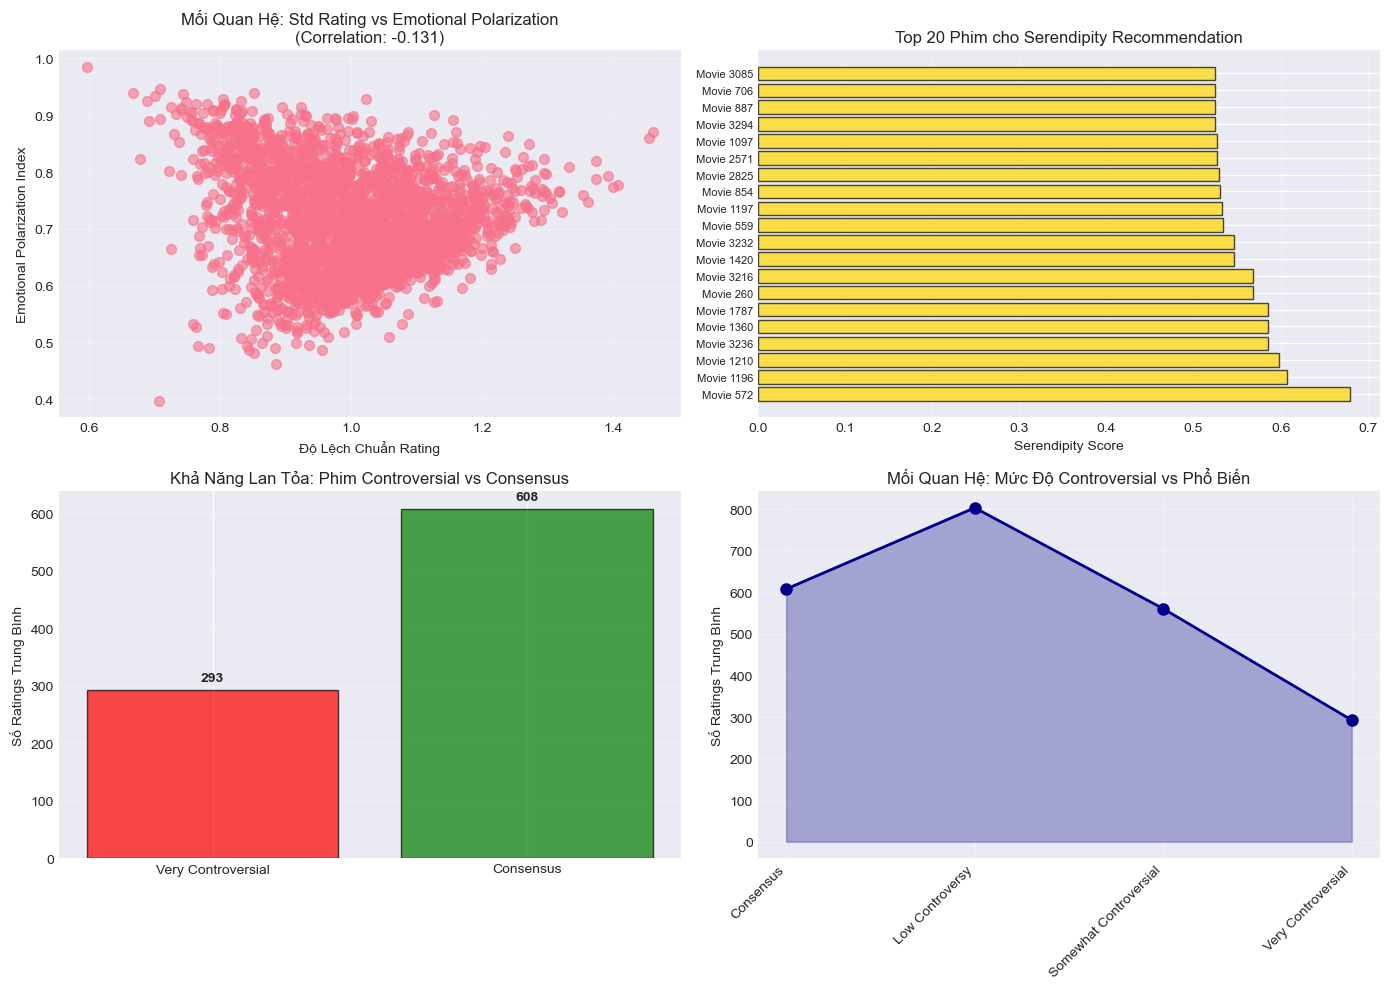

In [61]:
# Biểu đồ phân tích mở rộng
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Biểu đồ 1: Chỉ số phân cực cảm xúc vs Std Rating
movie_stats_simple['emotional_polarization'] = movie_stats_simple['movie_id'].apply(
    lambda x: polarization_index.get(
        data.loc[data['movie_id'] == x, 'title'].iloc[0] if x in data['movie_id'].values else None, 
        np.nan
    ) if x in data['movie_id'].values else np.nan
)
valid_for_scatter = movie_stats_simple.dropna(subset=['emotional_polarization', 'std_rating'])

axes[0, 0].scatter(valid_for_scatter['std_rating'], valid_for_scatter['emotional_polarization'], alpha=0.6, s=50)
axes[0, 0].set_xlabel('Độ Lệch Chuẩn Rating')
axes[0, 0].set_ylabel('Emotional Polarization Index')
axes[0, 0].set_title(f'Mối Quan Hệ: Std Rating vs Emotional Polarization\n(Correlation: {corr_polar:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# Biểu đồ 2: Serendipity Score
serendipity_top = serendipity_sorted.head(20)
axes[0, 1].barh(range(len(serendipity_top)), serendipity_top['serendipity_score'].values, color='gold', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(serendipity_top)))
axes[0, 1].set_yticklabels([f"Movie {mid}" for mid in serendipity_top['movie_id'].values], fontsize=8)
axes[0, 1].set_xlabel('Serendipity Score')
axes[0, 1].set_title('Top 20 Phim cho Serendipity Recommendation')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Biểu đồ 3: Virality so sánh
categories = ['Very Controversial', 'Consensus']
virality_values = [controversial_movies_list['num_ratings'].mean(), consensus_movies_list['num_ratings'].mean()]
colors_virality = ['red', 'green']
bars = axes[1, 0].bar(categories, virality_values, color=colors_virality, edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Số Ratings Trung Bình')
axes[1, 0].set_title('Khả Năng Lan Tỏa: Phim Controversial vs Consensus')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, virality_values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, val + 10, f'{val:.0f}', ha='center', va='bottom', fontweight='bold')

# Biểu đồ 4: Phân bố controversy level vs popularity
controversy_order = ['Consensus', 'Low Controversy', 'Somewhat Controversial', 'Very Controversial']
popularity_by_controversy = []
for conv_level in controversy_order:
    avg_pop = movie_stats_simple[movie_stats_simple['controversy_level'] == conv_level]['num_ratings'].mean()
    popularity_by_controversy.append(avg_pop)

axes[1, 1].plot(range(len(controversy_order)), popularity_by_controversy, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[1, 1].fill_between(range(len(controversy_order)), popularity_by_controversy, alpha=0.3, color='darkblue')
axes[1, 1].set_xticks(range(len(controversy_order)))
axes[1, 1].set_xticklabels(controversy_order, rotation=45, ha='right')
axes[1, 1].set_ylabel('Số Ratings Trung Bình')
axes[1, 1].set_title('Mối Quan Hệ: Mức Độ Controversial vs Phổ Biến')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('extended_analysis.png', dpi=100, bbox_inches='tight')
plt.show()